### Import Required Packages

In [344]:
import pandas as pd
import py_entitymatching as em
import numpy as np
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from urllib2 import urlopen
import matplotlib.pyplot as plt
from nltk.metrics import edit_distance, jaccard_distance
from IPython.display import Image  
import pydotplus
import warnings
warnings.filterwarnings('ignore')

# Import Datasets & Create Features
1. __"Golden Data"__
    1. Labeled dataset of 350 instances
2. __Spoj & Codechef tables__
    1. Contains scraped data (this is the data that we have processed in previous steps)
3. __Merge Spoj & Codechef to one table__
4. __Create features to train model__
    1. Exact title match
    2. Difference in description word length
    3. Jaccard similarity in description
    4. Edit distance in title

In [192]:
# Step 1: Golden Data
labeled_data = pd.read_csv("labeled_set.csv")
train_data, test_data = train_test_split(labeled_data, test_size=0.125, random_state=42)
train_data.head(5)

,ltable_problem_code,rtable_problem_code,Match (0 / 1)
46,NOVICE21,DETDET,0
321,ACMNSIT4,ASYA2,0
338,EASYMATC,BIGO02,0
70,HS10SQFT,SUM1,0
374,XMEDIAN,SNON06,0


In [193]:
# Step 2: Load Spoj & Codechef raw (preprocessed in previous steps) data
table_spoj = "https://raw.githubusercontent.com/KaranTalreja/CS638/master/spoj/json/spoj_blocking.csv?token=AKuoLY5MivG2TZG4d-muAPxqyxMxTEILks5YOF8cwA%3D%3D"
table_A = pd.read_csv(urlopen(table_spoj)).drop("Unnamed: 0", axis=1)
table_A["words"] = table_A["description"].fillna("") + table_A["input"].fillna("") + table_A["output"].fillna("")
table_A = table_A.drop(["description", "input", "output"], axis=1)

table_codechef = "https://raw.githubusercontent.com/KaranTalreja/CS638/master/codechef/data/codechef_blocking.csv?token=AKuoLXwjsuxUcagsz8a-rKDmRJpIx82Wks5YOF80wA%3D%3D"
table_B = pd.read_csv(urlopen(table_codechef))
table_B["words"] = table_B["description"].fillna("") + table_B["input"].fillna("") + table_B["output"].fillna("")
table_B = table_B.drop(["description", "input", "output"], axis=1)

In [194]:
# Step 3: Merge Spoj & Codechef to one table

training = pd.DataFrame()

for i,j in train_data.iterrows():
    A_title, A_solve_rate_normalized, A_words = table_A[table_A["title"] == j["ltable_problem_code"]].drop("difficulty_normalized", axis=1).values[0]
    A_index = table_A[table_A["title"] == j["ltable_problem_code"]].drop("difficulty_normalized", axis=1).index.values[0]
    
    B_title, B_solve_rate_normalized, B_words = table_B[table_B["title"] == j["rtable_problem_code"]].drop("Unnamed: 0", axis=1).values[0]
    B_index = table_B[table_B["title"] == j["rtable_problem_code"]].drop("Unnamed: 0", axis=1).index.values[0]
    
    match = j["Match (0 / 1)"]
    
    training = training.append([{
                "index": i,
                "A_index": A_index,
                "A_title": A_title,
                "A_solve_rate_normalized": A_solve_rate_normalized,
                "A_words": A_words,
                "B_index": B_index,
                "B_title": B_title,
                "B_solve_rate_normalized": B_solve_rate_normalized,
                "B_words": B_words,
                "match": match,
            }])

training = training.set_index("index")

In [206]:
# Step 4: Create features to train model

def exact_match_title(df):
    if df["A_title"] == df["B_title"]:
        return 1
    else:
        return 0
    
def words_length(df):
    A_word_len = len(df["A_words"].split(" "))
    B_word_len = len(df["B_words"].split(" "))
    return abs(A_word_len - B_word_len)

def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

def jaccard_A_B(df):
    A_word_len = df["A_words"].split(" ")
    B_word_len = df["B_words"].split(" ")
    return jaccard_similarity(A_word_len, B_word_len)

def title_edit_dist(df):
    A_title = df["A_title"]
    B_title = df["B_title"]
    return edit_distance(A_title, B_title)
    
training["exact_title_match"] = training.apply(exact_match_title, axis=1)
training["diff_in_words_len"] = training.apply(words_length, axis=1)
training["jaccard_sim"] = training.apply(jaccard_A_B, axis=1)
training["edit_dist"] = training.apply(title_edit_dist, axis=1)
training_features = training[["match","exact_title_match","diff_in_words_len","jaccard_sim", "edit_dist"]]

In [207]:
training_features.head()

,match,exact_title_match,diff_in_words_len,jaccard_sim,edit_dist
index,,,,,
46,0,0,86,0.131387,7
321,0,0,61,0.188235,6
338,0,0,8,0.116667,8
70,0,0,95,0.150538,7
374,0,0,28,0.371795,7


# Begin Building & Evaluating ML Models
1. __Split data into Training & Validation sets__
    1. Validation set is 30% of golden data
2. __Build and Evaluate ML models__
    1. Logistic Regression Classifier
    2. Support Vector Machine
    3. Decision Tree Classifier
    4. Random Forrest Classifier
    5. Naïve Bayes Classifier (Gaussian NB)
3. __Test the fit of each model with 10-fold cross-validation__

### Split Training set into data and labels

In [325]:
X = training_features.reset_index().drop(["match","index"], axis=1)
y = training_features.match.reset_index().drop("index", axis=1)
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.30, random_state=33)

### Logistic Regression Classifier

In [356]:
# Train Model
log_model = LogisticRegression(penalty="l1", class_weight="balanced")
log_model_fit = log_model.fit(X_train, y_train)

# Use Model to Predict
log_pred = log_model_fit.predict(X_validate)

# Evaluate Model
print classification_report(y_validate, log_pred)
print confusion_matrix(y_validate, log_pred)

             precision    recall  f1-score   support

          0       0.95      0.98      0.97        86
          1       0.88      0.79      0.83        19

avg / total       0.94      0.94      0.94       105

[[84  2]
 [ 4 15]]


In [357]:
# Cross Validation of Model
k_fold = KFold(n_splits=10, shuffle=True, random_state=8)
print "10-Fold Cross Validation Results:"
print "  Mean Precision: %.4f" % cross_val_score(log_model, X, y, cv=k_fold, n_jobs=-1, scoring="precision").mean()
print "  Mean Recall: %.4f" % cross_val_score(log_model, X, y, cv=k_fold, n_jobs=-1, scoring="recall").mean()
print "  Mean F1-score: %.4f" % cross_val_score(log_model, X, y, cv=k_fold, n_jobs=-1, scoring="f1").mean()

10-Fold Cross Validation Results:
  Mean Precision: 0.9023
  Mean Recall: 0.9098
  Mean F1-score: 0.9017


### SVM Classifier

In [358]:
# Train Model
svm_model = SVC(kernel="linear", class_weight="balanced")
svm_model_fit = svm_model.fit(X_train, y_train)

# Use Model to Predict
svm_pred = svm_model_fit.predict(X_validate)

# Evaluate Model
print classification_report(y_validate, svm_pred)
print confusion_matrix(y_validate, svm_pred)

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        86
          1       1.00      0.79      0.88        19

avg / total       0.96      0.96      0.96       105

[[86  0]
 [ 4 15]]


In [359]:
# Cross Validation of Model
print "10-Fold Cross Validation Results:"
print "  Mean Precision: %.4f" % cross_val_score(svm_model, X, y, cv=k_fold, n_jobs=-1, scoring="precision").mean()
print "  Mean Recall: %.4f" % cross_val_score(svm_model, X, y, cv=k_fold, n_jobs=-1, scoring="recall").mean()
print "  Mean F1-score: %.4f" % cross_val_score(svm_model, X, y, cv=k_fold, n_jobs=-1, scoring="f1").mean()

10-Fold Cross Validation Results:
  Mean Precision: 0.9817
  Mean Recall: 0.9014
  Mean F1-score: 0.9365


### Decision Tree Classifier

In [364]:
# Train Model
DT_model = DecisionTreeClassifier(class_weight="balanced", random_state=23)
DT_model_fit = DT_model.fit(X_train, y_train)

# Use Model to Predict
DT_pred = DT_model_fit.predict(X_validate)

# Evaluate Model
print classification_report(y_validate, DT_pred)
print confusion_matrix(y_validate, DT_pred)   

             precision    recall  f1-score   support

          0       0.97      0.99      0.98        86
          1       0.94      0.84      0.89        19

avg / total       0.96      0.96      0.96       105

[[85  1]
 [ 3 16]]


In [365]:
# Cross Validation of Model
print "10-Fold Cross Validation Results:"
print "  Mean Precision: %.4f" % cross_val_score(DT_model, X, y, cv=k_fold, n_jobs=-1, scoring="precision").mean()
print "  Mean Recall: %.4f" % cross_val_score(DT_model, X, y, cv=k_fold, n_jobs=-1, scoring="recall").mean()
print "  Mean F1-score: %.4f" % cross_val_score(DT_model, X, y, cv=k_fold, n_jobs=-1, scoring="f1").mean()

10-Fold Cross Validation Results:
  Mean Precision: 0.9200
  Mean Recall: 0.8931
  Mean F1-score: 0.8966


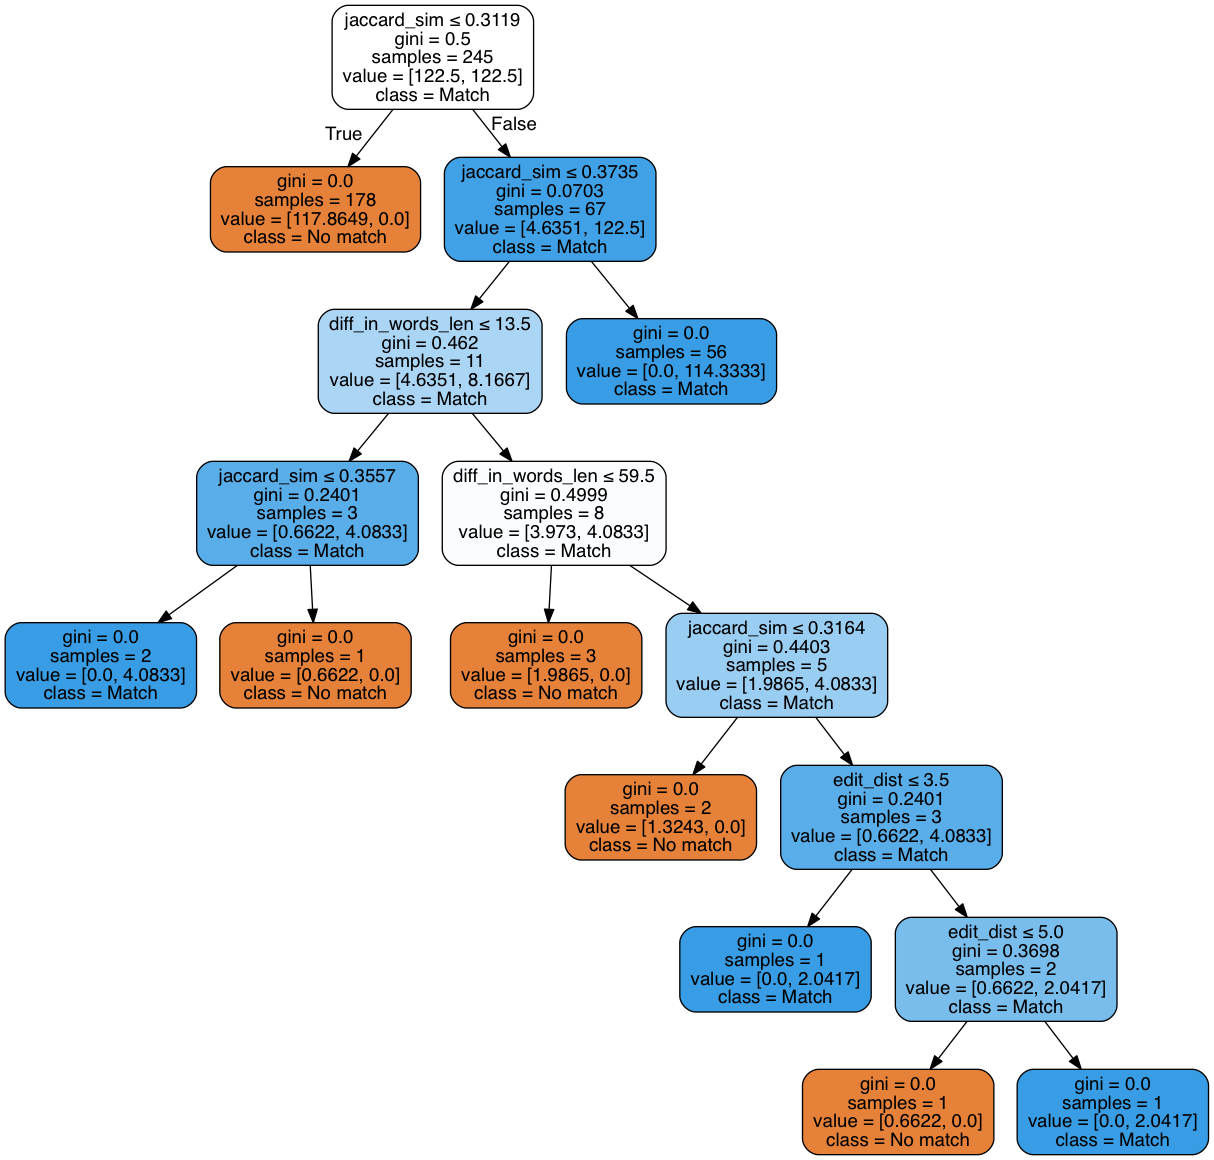

In [366]:
dot_data = export_graphviz(DT_model_fit, out_file=None, 
                         feature_names=X_validate.columns.values,  
                         class_names=["No match", "Match"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

### Random Forest Classifier

In [369]:
# Train Model
RF_model = RandomForestClassifier(n_estimators=15, max_depth=5, random_state=44, 
                                  class_weight="balanced")
RF_model_fit = RF_model.fit(X_train, y_train)

# Use Model to Predict
RF_pred = RF_model_fit.predict(X_validate)

# Evaluate Model
print classification_report(y_validate, RF_pred)
print confusion_matrix(y_validate, RF_pred)

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        86
          1       1.00      0.79      0.88        19

avg / total       0.96      0.96      0.96       105

[[86  0]
 [ 4 15]]


In [370]:
# Cross Validation of Model
print "10-Fold Cross Validation Results:"
print "  Mean Precision: %.4f" % cross_val_score(RF_model, X, y, cv=k_fold, n_jobs=-1, scoring="precision").mean()
print "  Mean Recall: %.4f" % cross_val_score(RF_model, X, y, cv=k_fold, n_jobs=-1, scoring="recall").mean()
print "  Mean F1-score: %.4f" % cross_val_score(RF_model, X, y, cv=k_fold, n_jobs=-1, scoring="f1").mean()

10-Fold Cross Validation Results:
  Mean Precision: 0.9448
  Mean Recall: 0.8931
  Mean F1-score: 0.9139


### Naïve Bayes Classifier

In [371]:
# Train Model
NB_model = GaussianNB()
NB_model_fit = NB_model.fit(X_train, y_train)

# Use Model to Predict
NB_pred = NB_model_fit.predict(X_validate)

# Evaluate Model
print classification_report(y_validate, NB_pred)
print confusion_matrix(y_validate, NB_pred)   

             precision    recall  f1-score   support

          0       0.93      1.00      0.97        86
          1       1.00      0.68      0.81        19

avg / total       0.95      0.94      0.94       105

[[86  0]
 [ 6 13]]


In [372]:
# Cross Validation of Model
print "10-Fold Cross Validation Results:"
print "  Mean Precision: %.4f" % cross_val_score(NB_model, X, y, cv=k_fold, n_jobs=-1, scoring="precision").mean()
print "  Mean Recall: %.4f" % cross_val_score(NB_model, X, y, cv=k_fold, n_jobs=-1, scoring="recall").mean()
print "  Mean F1-score: %.4f" % cross_val_score(NB_model, X, y, cv=k_fold, n_jobs=-1, scoring="f1").mean()

10-Fold Cross Validation Results:
  Mean Precision: 1.0000
  Mean Recall: 0.8309
  Mean F1-score: 0.8975
